# US Census Data Cleaning

#### In this project, we'll be looking through US Census Data stored across 10 CSV files. This data will be cleaned by removing any duplicate values, completing any missing data, separating columns when they need to be, and organizing the data in a way that makes it easier to represent visually.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

We'll begin by importing the necessary libraries for the project. Note that because the data is scattered across ten files, `glob` is being used to make the process of opening and putting those files into a dataframe a lot easier.

## Compiling necessary data

In [2]:
census_files = glob.glob("states*.csv")
census_data = []
for census_file in census_files:
  file_content = pd.read_csv(census_file)
  file_df = pd.DataFrame(file_content)
  census_data.append(file_df)
us_census = pd.concat(census_data).reset_index(drop=True)

Here, `glob()` will open files `states0.csv` through `states9.csv` and for each file in that list, the a DataFrame with its contents is created, which is then appended to a list of DataFrames: `census_data`. Finally, the variable `us_census` contains a concatenation of all these DataFrames to form one large set of data we can visually more easily. `reset_index()` is being called because each DataFrame that's being concatenated has its own index from 0-5, thus, the index would end up repeating for each file, restarting back at 0 after 5 over and over. 

## Initial presentation of the data

In [3]:
us_census.head()

,Unnamed: 0,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,0,Alabama,4830620,3.7516156462584975%,61.878656462585%,31.25297619047618%,0.4532312925170065%,1.0502551020408146%,0.03435374149659865%,$43296.35860306644,2341093M_2489527F
1,1,Alaska,733375,5.909580838323351%,60.910179640718574%,2.8485029940119775%,16.39101796407186%,5.450299401197604%,1.0586826347305378%,$70354.74390243902,384160M_349215F
2,2,Arizona,6641928,29.565921052631502%,57.120000000000026%,3.8509868421052658%,4.35506578947368%,2.876578947368419%,0.16763157894736833%,$54207.82095490716,3299088M_3342840F
3,3,Arkansas,2958208,6.215474452554738%,71.13781021897813%,18.968759124087573%,0.5229197080291965%,1.1423357664233578%,0.14686131386861315%,$41935.63396778917,1451913M_1506295F
4,4,California,38421464,37.291874687968054%,40.21578881677474%,5.677396405391911%,0.40529206190713685%,13.052234148776776%,0.35141038442336353%,$67264.78230266465,19087135M_19334329F


In [4]:
us_census.dtypes

Unnamed: 0     int64
State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income        object
GenderPop     object
dtype: object

There's a few things that can be noticed right away and at least one small change that can be made before cleaning any data. Some observations of the basic data:
- Race breakdown contains a percent sign that can be removed to create numeric values (currently object type)
- Income contains a dollar sign that can be removed to create numeric values (currently object type)
- Gender population data is all on one column, can be separated and then further clean to create a numeric value
- Extra column 'Unnamed: 0' which serves no real purpose after resetting the index earlier.

In [5]:
us_census.pop('Unnamed: 0').reset_index()
us_census.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,Alabama,4830620,3.7516156462584975%,61.878656462585%,31.25297619047618%,0.4532312925170065%,1.0502551020408146%,0.03435374149659865%,$43296.35860306644,2341093M_2489527F
1,Alaska,733375,5.909580838323351%,60.910179640718574%,2.8485029940119775%,16.39101796407186%,5.450299401197604%,1.0586826347305378%,$70354.74390243902,384160M_349215F
2,Arizona,6641928,29.565921052631502%,57.120000000000026%,3.8509868421052658%,4.35506578947368%,2.876578947368419%,0.16763157894736833%,$54207.82095490716,3299088M_3342840F
3,Arkansas,2958208,6.215474452554738%,71.13781021897813%,18.968759124087573%,0.5229197080291965%,1.1423357664233578%,0.14686131386861315%,$41935.63396778917,1451913M_1506295F
4,California,38421464,37.291874687968054%,40.21578881677474%,5.677396405391911%,0.40529206190713685%,13.052234148776776%,0.35141038442336353%,$67264.78230266465,19087135M_19334329F


The last item on our list happens to be the easiest one, so we'll start with that. We'll renamed the unnamed column to **ID** and then set it as our index. 

## Cleaning gender and income data

We'll be using this data to create a scatterplot showing average income vs. proportion of women per state. Getting a numeric value out of the income column is fairly straightforward and can be done using a little regex. We'll also use `to_numeric` to convert the column into a numeric value.

In [6]:
us_census['Income'] = pd.to_numeric(us_census['Income'].str.replace('[\$]', '', regex=True))

With that done, we can now work on separating the GenderPop column into two columns, one male and one female. ``%%capture`` is being used to suppress the output generated by `us_census.pop('GenderPop)`. We'll look at the table and the data types in a moment anyway to confirm.

In [7]:
%%capture
split_genderpop = us_census['GenderPop'].str.split('_', expand=True)
us_census['MalePop'] = split_genderpop.get(0)
us_census['FemalePop'] = split_genderpop.get(1)
us_census.pop('GenderPop')

With the original **GenderPop** column removed and two new columns created (**MalePop** and **FemalePop**) we can once again use a little regex to remove the **M** and **F** from the values, then convert them into numeric values. Regex is not necessary, as slicing the string using a negative index can also accomplish this task.

In [8]:
us_census['MalePop'] = pd.to_numeric(us_census['MalePop'].str.replace('[\w*]$', '', regex=True))
us_census['FemalePop'] = pd.to_numeric(us_census['FemalePop'].str.replace('[\w*]$', '', regex=True))

Let's visualize our data again and check our data types. We don't need to view *all* the data, so we'll simply call the columns we want to see. 

In [9]:
us_census[['State', 'TotalPop', 'Income', 'MalePop', 'FemalePop']].head()

,State,TotalPop,Income,MalePop,FemalePop
0,Alabama,4830620,43296.358603,2341093,2489527.0
1,Alaska,733375,70354.743902,384160,349215.0
2,Arizona,6641928,54207.820955,3299088,3342840.0
3,Arkansas,2958208,41935.633968,1451913,1506295.0
4,California,38421464,67264.782303,19087135,19334329.0


In [10]:
us_census.dtypes

State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income       float64
MalePop        int64
FemalePop    float64
dtype: object

**Income** is now properly a `float` and **MalePop** is an `int` but we notice that **FemalePop** is also a `float`. This is because some values could not be converted to integers, which would indicate that this column contains `NaN` or `null` values. Let's verify that, and let's also make sure there aren't any `null` values in **MalePop**

In [11]:
print(us_census['FemalePop'].isnull().value_counts())
print(us_census['MalePop'].isnull().value_counts())

False    57
True      3
Name: FemalePop, dtype: int64
False    60
Name: MalePop, dtype: int64


We can see that `isnull().value_counts()` returns `True` for 3 rows in **FemalePop**. That means we have 3 rows where the female population data is `null`. Not a problem! We see that **MalePop** does not have any rows with `null` values, and since we also have a column that includes **TotalPop**, we can simply subtract our male population from our total population to obtain the missing values.

In [12]:
us_census.fillna(value={'FemalePop': us_census['TotalPop'] - us_census['MalePop']}, inplace=True)

Let's doublecheck for `null` values in **FemalePop**

In [13]:
us_census['FemalePop'].isnull().value_counts()

False    60
Name: FemalePop, dtype: int64

Perfect! And because consistency is a beautiful thing, let's take this opportunity to change that column to integer instead of float.

In [14]:
us_census['FemalePop'] = us_census['FemalePop'].astype(int)

In [15]:
us_census[['State', 'TotalPop', 'Income', 'MalePop', 'FemalePop']].head(10)

,State,TotalPop,Income,MalePop,FemalePop
0,Alabama,4830620,43296.358603,2341093,2489527
1,Alaska,733375,70354.743902,384160,349215
2,Arizona,6641928,54207.820955,3299088,3342840
3,Arkansas,2958208,41935.633968,1451913,1506295
4,California,38421464,67264.782303,19087135,19334329
5,Colorado,5278906,64657.801787,2648667,2630239
6,Colorado,5278906,64657.801787,2648667,2630239
7,Connecticut,3593222,76146.560588,1751607,1841615
8,Delaware,926454,61827.976636,448413,478041
9,District of Columbia,647484,75466.363636,306674,340810


Our data is now clean, in the correct format, and there are no `null` values. There's still a problem, however. We can see in index 5 and 6 that there is an obvious duplicate value. There's potentially other duplicates somewhere in there, so let's `drop_duplicates()` and `reset_index()` once more.

In [16]:
us_census = us_census.drop_duplicates(subset='State').reset_index()
us_census[['State', 'TotalPop', 'Income', 'MalePop', 'FemalePop']].head(10)

,State,TotalPop,Income,MalePop,FemalePop
0,Alabama,4830620,43296.358603,2341093,2489527
1,Alaska,733375,70354.743902,384160,349215
2,Arizona,6641928,54207.820955,3299088,3342840
3,Arkansas,2958208,41935.633968,1451913,1506295
4,California,38421464,67264.782303,19087135,19334329
5,Colorado,5278906,64657.801787,2648667,2630239
6,Connecticut,3593222,76146.560588,1751607,1841615
7,Delaware,926454,61827.976636,448413,478041
8,District of Columbia,647484,75466.363636,306674,340810
9,Florida,19645772,50690.194987,9600009,10045763


## Plotting the data
After all that cleaning and organizing, we can finally create the scatterplot.

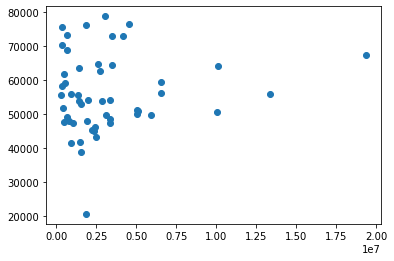

In [17]:
plt.scatter(us_census['FemalePop'], us_census['Income'])
plt.show()

## Histogram for race data
We'll now be working with race data, we'll be selecting those columns whenever we print the table from now on since we no longer need to visualize **Income**, **TotalPop**, **MalePop** or **FemalePop**. Let's check the data and see what it looks like.

In [18]:
us_census[['State', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']].head()

,State,Hispanic,White,Black,Native,Asian,Pacific
0,Alabama,3.7516156462584975%,61.878656462585%,31.25297619047618%,0.4532312925170065%,1.0502551020408146%,0.03435374149659865%
1,Alaska,5.909580838323351%,60.910179640718574%,2.8485029940119775%,16.39101796407186%,5.450299401197604%,1.0586826347305378%
2,Arizona,29.565921052631502%,57.120000000000026%,3.8509868421052658%,4.35506578947368%,2.876578947368419%,0.16763157894736833%
3,Arkansas,6.215474452554738%,71.13781021897813%,18.968759124087573%,0.5229197080291965%,1.1423357664233578%,0.14686131386861315%
4,California,37.291874687968054%,40.21578881677474%,5.677396405391911%,0.40529206190713685%,13.052234148776776%,0.35141038442336353%


Here we have percentages, but they include a percent sign, which we'll have to remove in order to turn these columns into numeric values. We'll be using a very similar process to the one we used before, and a little regex to clean these values. First we'll define a list of the races in this DataFrame, which we'll iterate through later.

In [19]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

Now let's loop through them to remove the percent sign, and let's take that opportunity to check for null values, as well.

In [20]:
for race in races:
    us_census[race] = pd.to_numeric(us_census[race].str.replace('[\%]$', '', regex=True))
    print(us_census[race].isnull().value_counts())

False    51
Name: Hispanic, dtype: int64
False    51
Name: White, dtype: int64
False    51
Name: Black, dtype: int64
False    51
Name: Native, dtype: int64
False    51
Name: Asian, dtype: int64
False    47
True      4
Name: Pacific, dtype: int64


It seems that our dataset is mostly complete, there's 4 missing values in the **Pacific** column. We can apply a similar solution as before. This time, we're working with a percent of population, and since all other race data is complete, all we need to do is add together all the non-Pacific values, and subtract them from 100. 

In [22]:
us_census.fillna(value={'Pacific' : 100 - (us_census['Hispanic'] + 
                                           us_census['White'] + us_census['Black'] + 
                                           us_census['Native'] + us_census['Asian'])}, inplace=True)

In [23]:
us_census['Pacific'].isnull().value_counts()

False    51
Name: Pacific, dtype: int64

Great! No more `null` values in our Pacific column. Our data is now clean and can now use a for loop once more to iterate through our `races` list and create our histograms! The following code iterates through the list, creates a histogram, and applies the appropriate labels to the axes, as well as a title that describes the histogram.

## Plotting histograms for race data

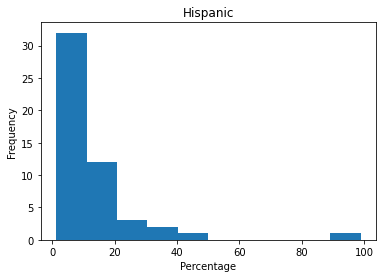

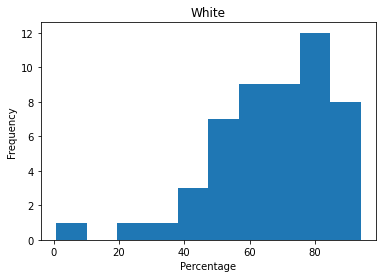

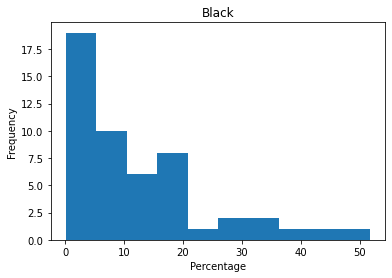

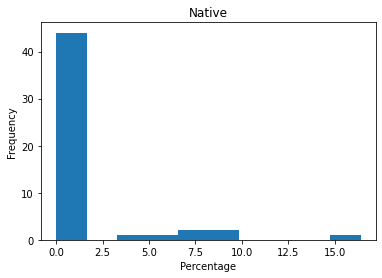

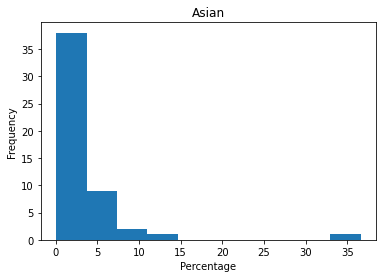

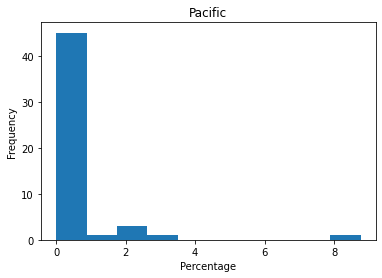

In [26]:
for race in races:
  plt.hist(us_census[race])
  plt.title(race)
  plt.xlabel('Percentage')
  plt.ylabel('Frequency')
  plt.show()